# Проект: ВШЭ ПСБ.Хак

## Описание задачи


После суровых трудовых будней всегда хочется с удовольствием провести свой отпуск и насладиться отдыхом. Тем не менее, на этом пути к счастью обычно возникают несколько преград: выбор желаемой гостиницы, заблаговременное бронирование, оплата, получение максимально возможной скидки и т.д. Как минимизировать свои риски и траты, и при этом получить желаемый уровень сервиса и отдых?

А что, если проанализировать данные по оплатам, бронированиям и отменам для сети гостиниц и попытаться найти скрытые зависимости с датами заезда, формой оплаты и другими признаками?

А если на этом не останавливаться и попытаться использовать найденные паттерны для создания нового банковского продукта, который сможет как помочь потенциальным клиентам с организацией отпуска, так и позволит банку и отелю остаться в плюсе?

Именно для создания такого инновационного продукта Вышка Онлайн совместно с Цифровой лабораторией ПСБ проводит хакатон ВШЭ ПСБ.Хак.


### Организация


Соревнование пройдет с 20-22 сентября 2024 в гибридном формате. Командам участникам необходимо пройти через два этапа:

* **Этап 1.** Технический. Решение задачи бинарной классификации с целью предсказания факта отмены бронирования
* **Этап 2.** Бизнесовый. На основе найденных зависимостей в рамках первого этапа, а также с учетом самостоятельно проведенного анализа рынка и существующих банковских и онлайн-туристических продуктов и программ лояльности, предложить новый банковский продукт для банка ПСБ.
В рамках первого этапа команды подгружают свои предсказания отмены бронирования на платформу, где происходит автоматическая проверка ответов на тестовой выборке. Первый этап соревнования завершается 22 сентября в 16:00.

Детали регистрации на платформе и особенности отправки решений будут подробно описаны после торжественного открытия хакатона 20 сентября.

В рамках второго этапа команды готовят презентацию предлагаемого продукта, которую будут защищать перед жюри 22 сентября, начиная с 17:00.

Для погружения участников в особенности банковского бизнеса и предметной области в течение субботы будет проводится серия мастер-классов. Отдельно с командами будут работать менторы, которые будут консультировать на протяжении всего периода соревнования.

### Данные
Данные представляют собой информацию о бронировании номеров различных категорий в разных гостиницах. Гостиницы с номерами 1 и 2 – один регион РФ, с номерами 3 и 4 – другой регион РФ. Структура данных следующая:



* № брони – идентификатор брони
* Номеров – количество номеров в бронировании
* Стоимость – стоимость номеров в рублях
* Внесена предоплата – сумма внесенной предоплаты
* Способ оплаты – один из 12 способов оплаты
* Дата бронирования – дата бронирования с точностью до минуты
* Дата отмены – дата отмены бронирования с точностью до минуты, если было
* Заезд – дата заезда с точностью до дня
* Ночей – количество ночей
* Выезд – дата выезда с точностью до дня
* Источник – онлайн-канал продаж
* Статус брони – один из 5 статусов
* Категория номера – описание категории номера. Если бронировалось несколько номеров, то идет сплошное описание с * нумерацией.
* Гостей – число гостей
* Гостиница – номер гостиницы

* Целевое поле – Дата отмены: если поле заполнено, то это соответствует целевому значению 1, иначе – 0. Статусы в поле Статус брони уточняют состояние и носят справочный характер (но могут помочь при построении модели).

В тестовой выборке отсутствуют столбцы Дата отмены и Статус брони.

### Метрика
Итоговой метрикой выступает ROC-AUC по столбцу Дата отмены.


### Лидерборд
Лидерборд технической части соревнования (метрика модели) в процессе соревнования считается по доступной для скачивания тестовой выборке. Окончание отправок всех решений 22 сентября в 16:00. Лидерборд скрывается от участников 22 сентября в 12:00 и открывается с итоговым результатом 22 сентября в 20:00.

### Итоговая оценка решения
Итоговая оценка соревнования формируется на основе технической части (40% результата) и защит решений в форме презентаций (60% результата). Экспертное жюри определяет оценку защит. Детали с критериями оценки второго этапа будут предоставлены командам отдельно.

## Загрузка данных

### Импорт библиотек

In [17]:
import pandas as pd
import requests
import re
from io import BytesIO
import os

### Функции

In [18]:
def github(url):
    response = requests.get(url)
    response.raise_for_status() 
    return BytesIO(response.content)

In [19]:
# Функция для загрузки файла из локальной папки или с GitHub
def load_f(file_path, github_url, file_type="xlsx"):
    try:
        # Сначала пытаемся загрузить из локальной папки
        if file_type == "xlsx":
            data = pd.read_excel(file_path, index_col=0)  # Устанавливаем первую колонку в качестве индекса
        elif file_type == "csv":
            data = pd.read_csv(file_path, index_col=0)  # Устанавливаем первую колонку в качестве индекса
        print(f"Файл загружен локально: {file_path}")
    except FileNotFoundError:
        # Если файл не найден, загружаем с GitHub
        print(f"Файл не найден локально, загружаю с GitHub: {github_url}")
        if file_type == "xlsx":
            data = pd.read_excel(download_file_from_github(github_url), index_col=0)  # Устанавливаем первую колонку в качестве индекса
        elif file_type == "csv":
            data = pd.read_csv(download_file_from_github(github_url), index_col=0)  # Устанавливаем первую колонку в качестве индекса
        print(f"Файл загружен с GitHub: {github_url}")
    return data

In [20]:
# Пути к локальным файлам и ссылки на GitHub
train_local_path = os.path.join('datasets', 'train.xlsx')
test_local_path = os.path.join('datasets', 'test.xlsx')
example_local_path = os.path.join('datasets', 'example.csv')

train_github_url = "https://github.com/EPrutskoy/MindGames_Hotel_Product/blob/3e23c7d7c49ec53e08e9e3d17468f26d286f6b4e/datasets/train.xlsx?raw=true"
test_github_url = "https://github.com/EPrutskoy/MindGames_Hotel_Product/blob/3e23c7d7c49ec53e08e9e3d17468f26d286f6b4e/datasets/test.xlsx?raw=true"
example_github_url = "https://github.com/EPrutskoy/MindGames_Hotel_Product/blob/3e23c7d7c49ec53e08e9e3d17468f26d286f6b4e/datasets/example.csv?raw=true"

# Загрузка файлов
train_data = load_f(train_local_path, train_github_url, file_type="xlsx")
test_data = load_f(test_local_path, test_github_url, file_type="xlsx")
example_data = load_f(example_local_path, example_github_url, file_type="csv")

Файл загружен локально: datasets\train.xlsx
Файл загружен локально: datasets\test.xlsx
Файл загружен локально: datasets\example.csv


### Загрузка таблиц

In [21]:
train_data.info()
test_data.info()
example_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26174 entries, 0 to 26173
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   № брони             26174 non-null  object        
 1   Номеров             26174 non-null  int64         
 2   Стоимость           26174 non-null  float64       
 3   Внесена предоплата  26174 non-null  int64         
 4   Способ оплаты       26174 non-null  object        
 5   Дата бронирования   26174 non-null  datetime64[ns]
 6   Дата отмены         5192 non-null   datetime64[ns]
 7   Заезд               26174 non-null  datetime64[ns]
 8   Ночей               26174 non-null  int64         
 9   Выезд               26174 non-null  datetime64[ns]
 10  Источник            26174 non-null  object        
 11  Статус брони        26174 non-null  object        
 12  Категория номера    26174 non-null  object        
 13  Гостей              26174 non-null  int64         


#### Таблица `train_data`

In [22]:
train_data.sample()

,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
4281,20220527-7492-131743994,1,17860.0,17860,Банк. карта [Кешбэк. МИР]: Эквайринг TravelLin...,2022-04-04 04:01:13,NaT,2022-05-27 15:00:00,2,2022-05-29 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2


In [23]:
train_data['Внесена предоплата'].unique()

array([     0,  12400,  12900, ..., 107100, 107300,  81770], dtype=int64)

In [24]:
train_data['Гостиница'].unique()

array([1, 4, 3, 2], dtype=int64)

In [25]:
train_data['Способ оплаты'].value_counts()

Способ оплаты
Банк. карта: Банк Россия (банк. карта)                                           13747
Отложенная электронная оплата: Банк Россия (банк. карта)                          4128
Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)     2539
Внешняя система оплаты (С предоплатой)                                            1875
Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)                 1614
Гарантия банковской картой                                                         876
При заселении                                                                      704
Внешняя система оплаты                                                             332
Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)                  170
Внешняя система оплаты (Оплата наличными)                                           69
Банк. карта: Эквайринг ComfortBooking (Банк. карта)                                 58
Внешняя система оплаты (Банко

In [26]:
train_data['Категория номера'].value_counts()

Категория номера
Номер «Стандарт»                                                                                                                                     16872
Номер «Студия»                                                                                                                                        4929
Апартаменты с 2 спальнями с отдельным входом                                                                                                          1957
Номер «Люкс»                                                                                                                                           759
Коттедж с 2 спальнями                                                                                                                                  720
Коттедж с 3 спальнями                                                                                                                                  676
1. Номер «Стандарт»\n2. Номер «Стандарт»             

In [29]:
train_data.columns = [
    'booking_number',        # № брони
    'room_count',            # Номеров
    'price',                 # Стоимость
    'prepayment_amount',     # Внесена предоплата
    'payment_method',        # Способ оплаты
    'booking_date',          # Дата бронирования
    'cancellation_date',     # Дата отмены
    'check_in',              # Заезд
    'nights',                # Ночей
    'check_out',             # Выезд
    'source',                # Источник
    'booking_status',        # Статус брони
    'room_category',         # Категория номера
    'guests',                # Гостей
    'hotel'                  # Гостиница
]

# Проверим, что столбцы изменились
print(train_data.columns)

Index(['booking_number', 'room_count', 'price', 'prepayment_amount',
       'payment_method', 'booking_date', 'cancellation_date', 'check_in',
       'nights', 'check_out', 'source', 'booking_status', 'room_category',
       'guests', 'hotel'],
      dtype='object')


In [38]:
train_data.columns

Index(['booking_number', 'room_count', 'price', 'prepayment_amount',
       'payment_method', 'booking_date', 'cancellation_date', 'check_in',
       'nights', 'check_out', 'source', 'booking_status', 'room_category',
       'guests', 'hotel'],
      dtype='object')

In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26174 entries, 0 to 26173
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   booking_number     26174 non-null  object        
 1   room_count         26174 non-null  int64         
 2   price              26174 non-null  float64       
 3   prepayment_amount  26174 non-null  int64         
 4   payment_method     26174 non-null  object        
 5   booking_date       26174 non-null  datetime64[ns]
 6   cancellation_date  5192 non-null   datetime64[ns]
 7   check_in           26174 non-null  datetime64[ns]
 8   nights             26174 non-null  int64         
 9   check_out          26174 non-null  datetime64[ns]
 10  source             26174 non-null  object        
 11  booking_status     26174 non-null  object        
 12  room_category      26174 non-null  object        
 13  guests             26174 non-null  int64         
 14  hotel      

In [34]:
test_data.sample()

,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
4598,20220713-7492-132546134,1,29400.0,10600,Банк. карта: Банк Россия (банк. карта),2022-04-07 14:20:52,2022-07-13 15:00:00,3,2022-07-16 12:00:00,Официальный сайт,Номер «Стандарт»,2,2


In [39]:
quantitative_columns = [
    'room_count',                # Номеров
    'price',                # Стоимость
    'prepayment_amount',      # Внесена предоплата
    'nights',               # Ночей
    'guests',               # Гостей
    'hotel'                 # Гостиница
]

categorical_columns = [
    'booking_number',       # № брони
    'payment_method',       # Способ оплаты
    'booking_date',         # Дата бронирования
    'cancellation_date',    # Дата отмены
    'check_in',             # Заезд
    'check_out',            # Выезд
    'source',               # Источник
    'booking_status',       # Статус брони
    'room_category'         # Категория номера
]

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

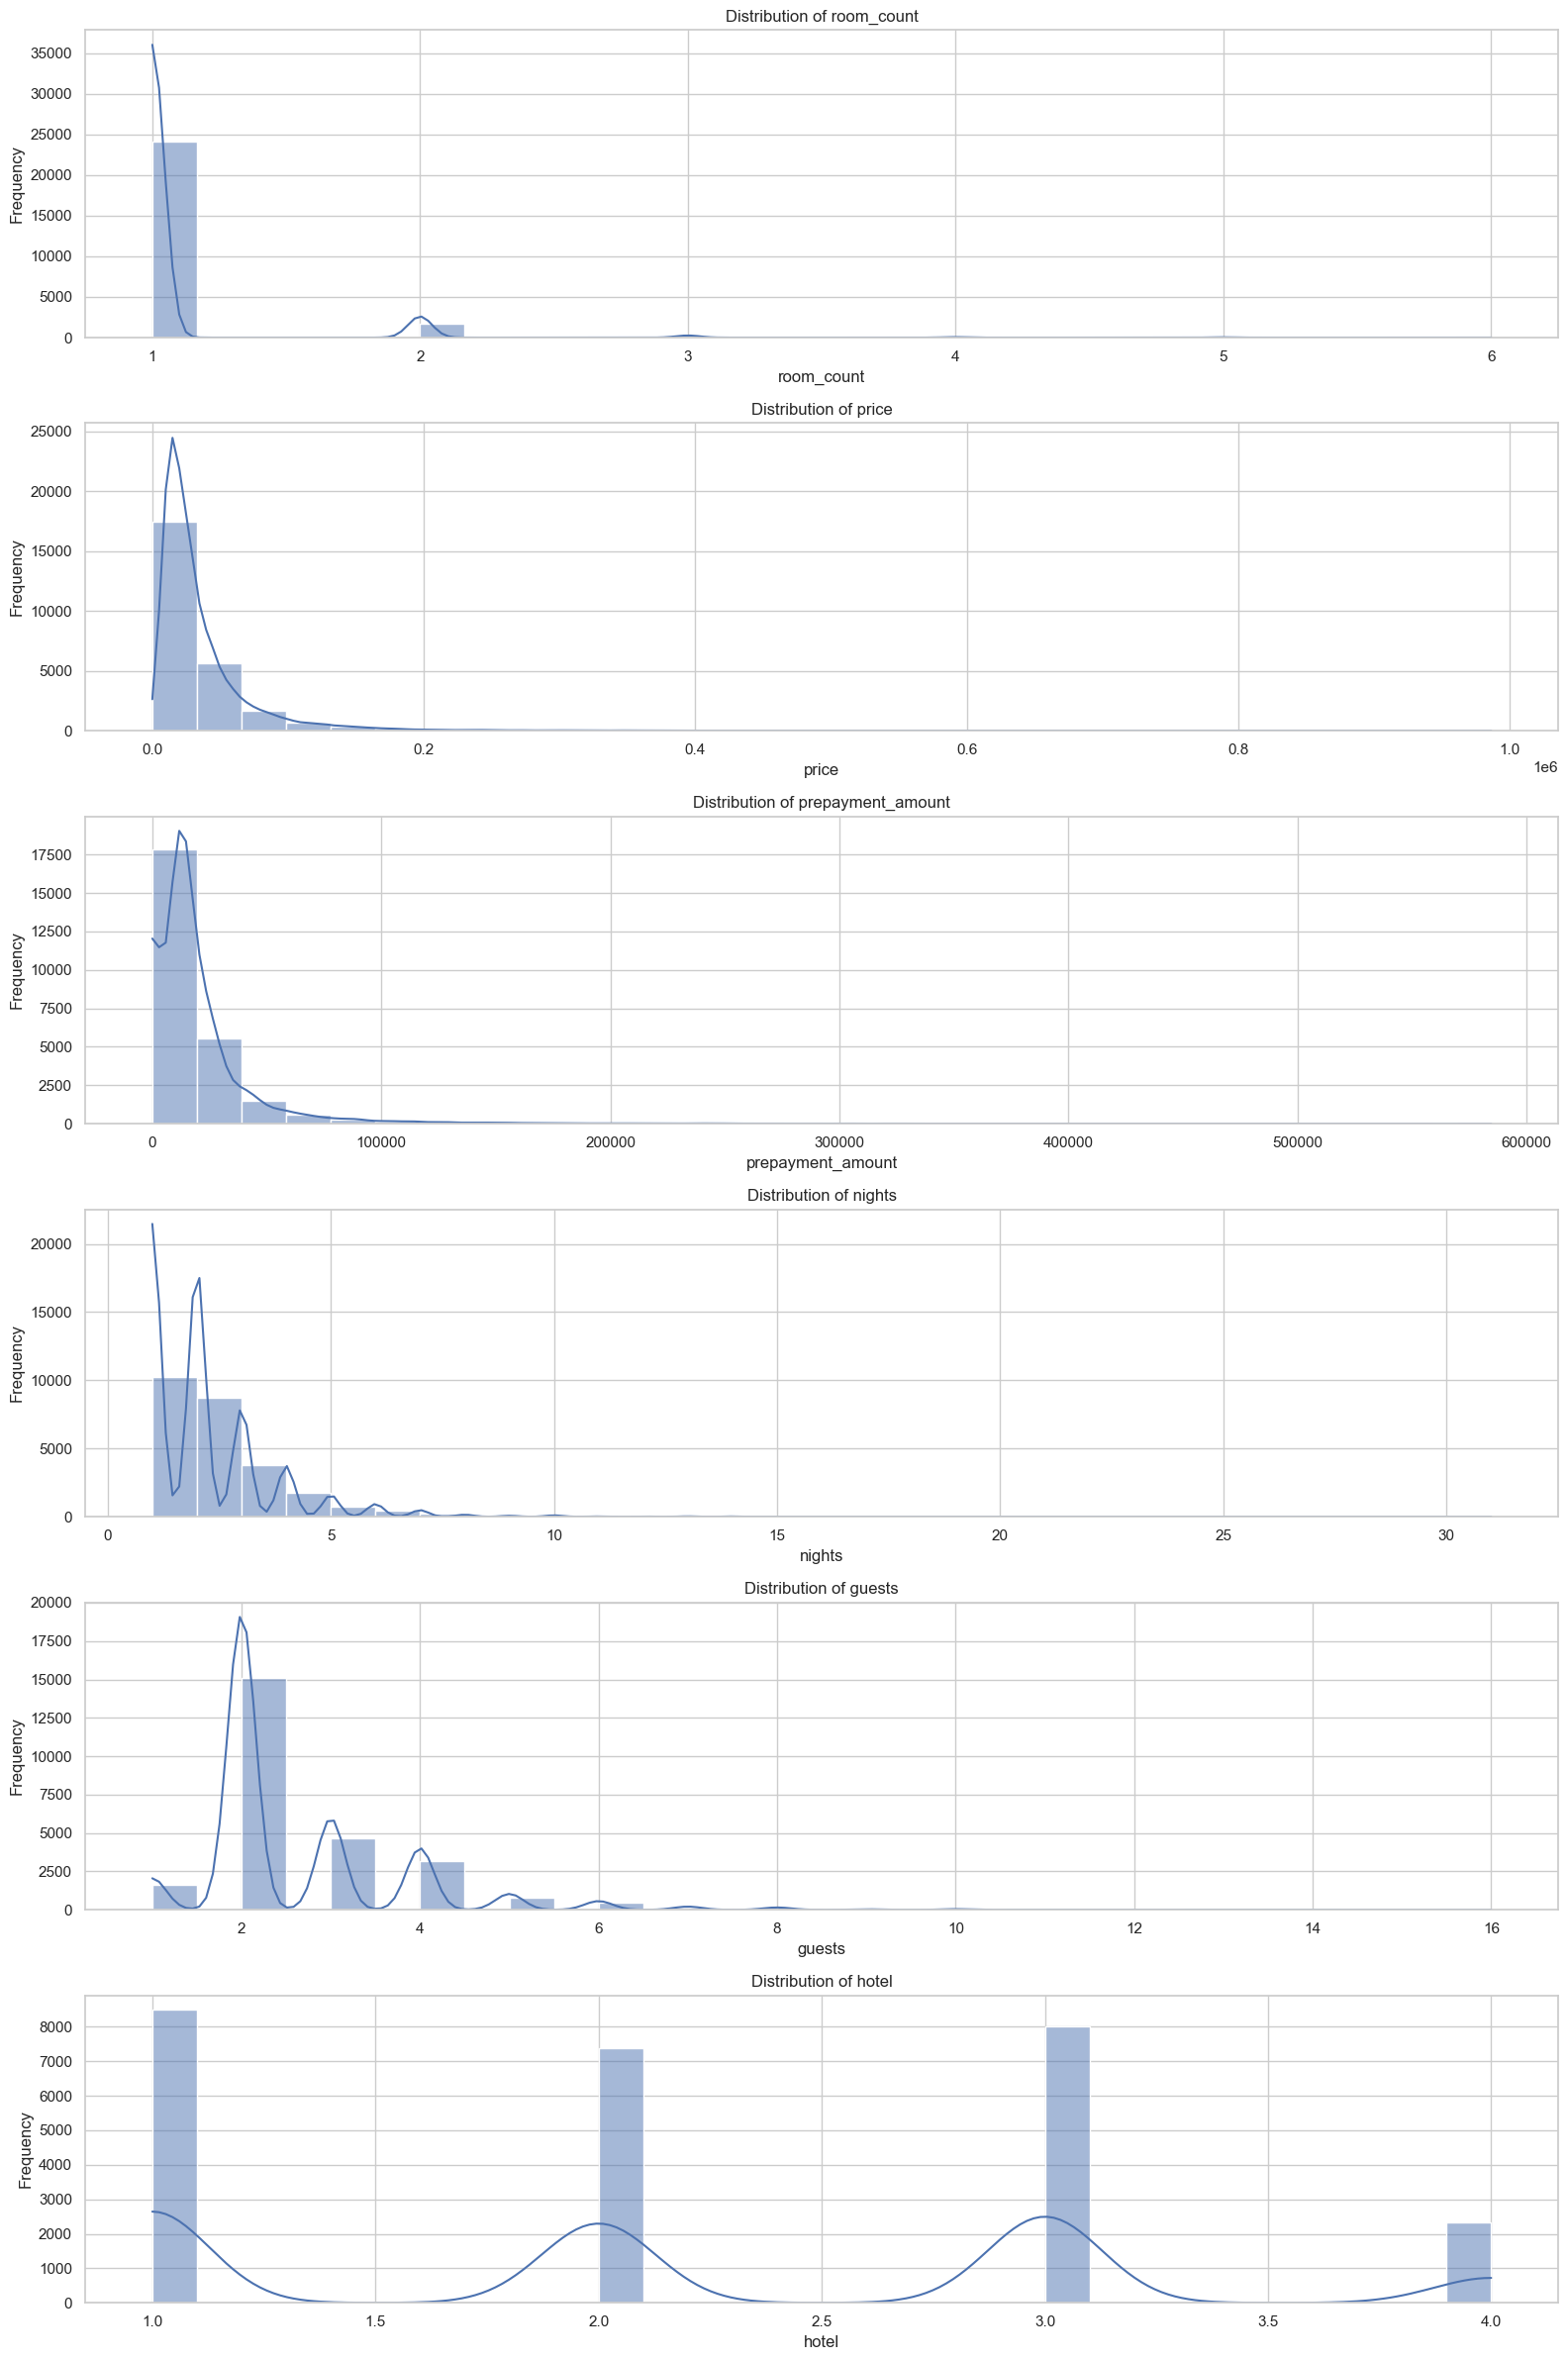

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Функция для построения графиков распределения по числовым элементам
def plot_distribution(df, quantitative_columns):
    # Устанавливаем стиль графиков
    sns.set(style="whitegrid")
    
    # Определяем количество графиков в зависимости от числа колонок
    num_columns = len(quantitative_columns)
    
    # Устанавливаем размер графиков
    plt.figure(figsize=(16, num_columns * 4))
    
    # Цикл для построения графиков для каждого количественного признака
    for i, column in enumerate(quantitative_columns, 1):
        plt.subplot(num_columns, 1, i)
        sns.histplot(df[column], kde=True, bins=30)  # Строим гистограмму с KDE
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
    # Показываем графики
    plt.tight_layout()
    plt.show()

# Пример использования

plot_distribution(train_data, quantitative_columns)

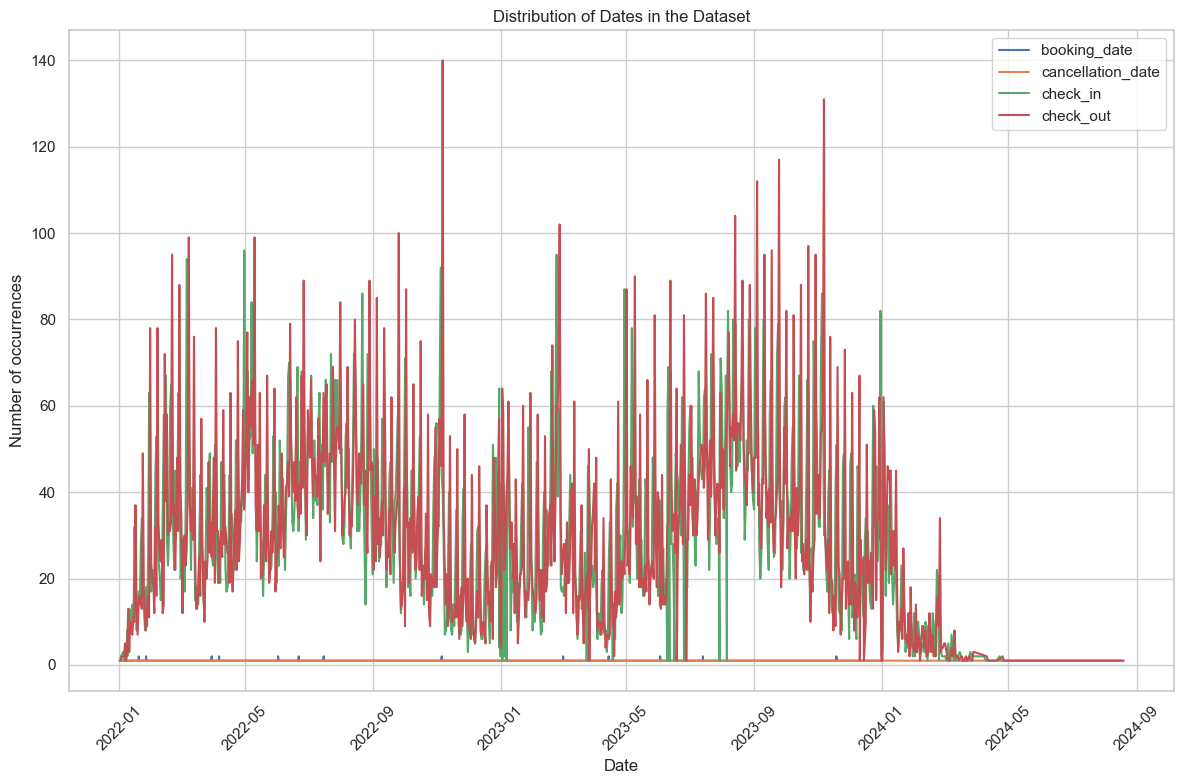

In [43]:
# Extracting date-related columns
date_columns = ['booking_date', 'cancellation_date', 'check_in', 'check_out']

# Convert date columns to datetime format (if not already)
train_data[date_columns] = train_data[date_columns].apply(pd.to_datetime)

# Plot the distribution of these date columns over time
plt.figure(figsize=(12, 8))

for col in date_columns:
    plt.plot(train_data[col].value_counts().sort_index(), label=col)

plt.title('Distribution of Dates in the Dataset')
plt.xlabel('Date')
plt.ylabel('Number of occurrences')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

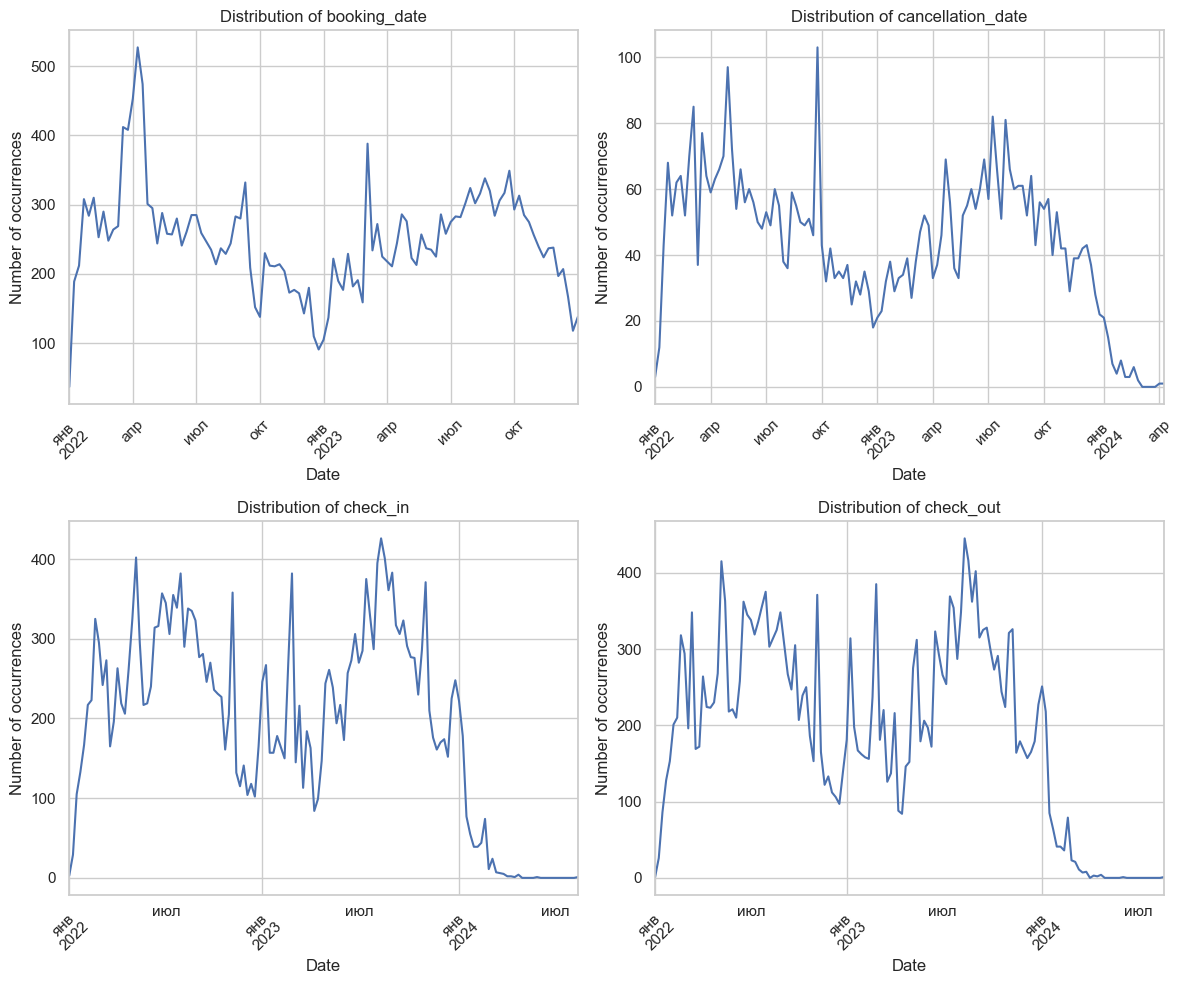

In [44]:
# Plot each date column separately with adjusted step for smoother lines
plt.figure(figsize=(12, 10))

for i, col in enumerate(date_columns, 1):
    plt.subplot(2, 2, i)
    train_data[col].value_counts().sort_index().resample('W').sum().plot()  # Resampling by week for smoother lines
    plt.title(f'Distribution of {col}')
    plt.xlabel('Date')
    plt.ylabel('Number of occurrences')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

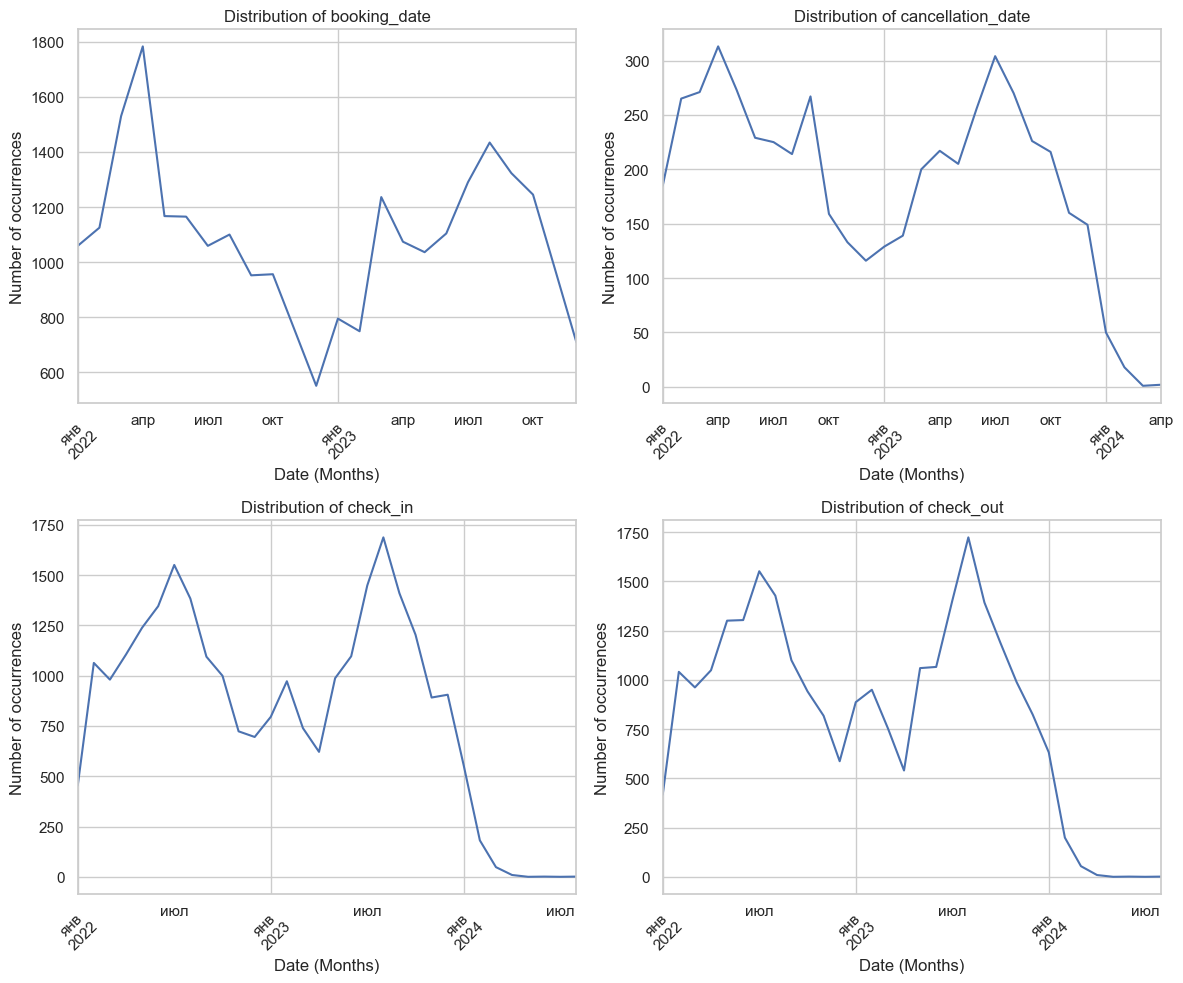

In [45]:
# Re-plotting the date distributions with month intervals on the x-axis
plt.figure(figsize=(12, 10))

for i, col in enumerate(date_columns, 1):
    plt.subplot(2, 2, i)
    train_data[col].value_counts().sort_index().resample('M').sum().plot()  # Resampling by month
    plt.title(f'Distribution of {col}')
    plt.xlabel('Date (Months)')
    plt.ylabel('Number of occurrences')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [50]:
# Convert date columns to datetime format (if not already)
train_data[date_columns] = train_data[date_columns].apply(pd.to_datetime)

# Finding the minimum and maximum date for each date-related column
date_ranges = train_data[date_columns].agg([min, max])

C:\Users\EPrutskoy\AppData\Local\Temp\ipykernel_10156\3099545717.py:5: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  date_ranges = train_data[date_columns].agg([min, max])
C:\Users\EPrutskoy\AppData\Local\Temp\ipykernel_10156\3099545717.py:5: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  date_ranges = train_data[date_columns].agg([min, max])


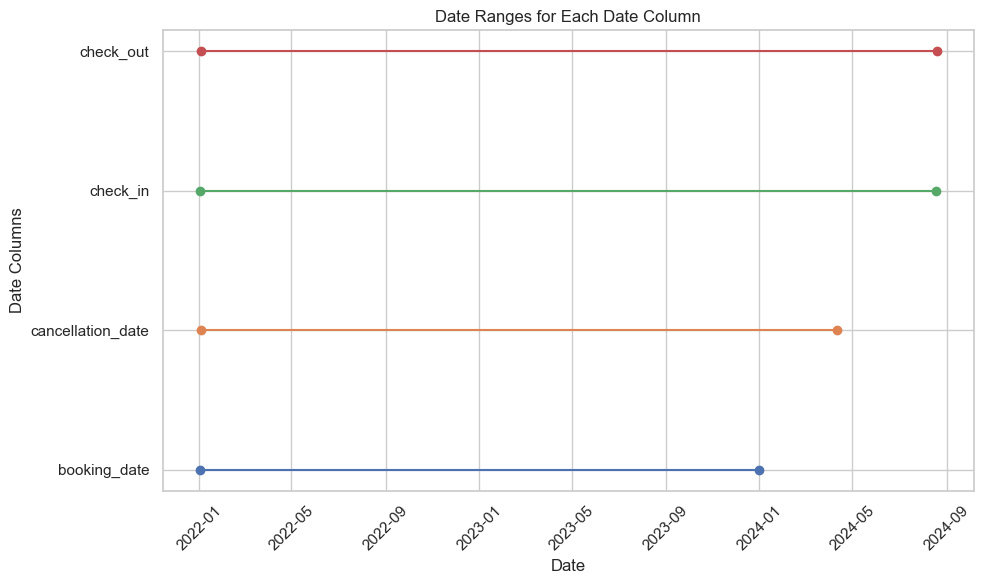

In [51]:
# Importing necessary libraries again after the session reset
import matplotlib.pyplot as plt

# Plotting the min and max date ranges for each date column
plt.figure(figsize=(10, 6))

for i, col in enumerate(date_columns):
    plt.plot([date_ranges[col]['min'], date_ranges[col]['max']], [i, i], marker='o', label=col)

plt.yticks(range(len(date_columns)), date_columns)
plt.title('Date Ranges for Each Date Column')
plt.xlabel('Date')
plt.ylabel('Date Columns')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Создадим новую колонку, извлекая центральную часть из 'booking_number'
train_data['central_booking_number'] = train_data['booking_number'].apply(lambda x: x.split('-')[1])

# Выведем первые несколько строк с новой колонкой
train_data[['booking_number', 'central_booking_number']].head()

,booking_number,central_booking_number
0,20230428-6634-194809261,6634
1,20220711-6634-144460018,6634
2,20221204-16563-171020423,16563
3,20230918-7491-223512699,7491
4,20230529-6634-200121971,6634


In [54]:
train_data.central_booking_number.unique()

array(['6634', '16563', '7491', '7492'], dtype=object)

In [55]:
train_data.source.unique()

array(['Яндекс.Путешествия', 'Официальный сайт', 'Bronevik.com(new)',
       'booking.com', 'Бронирование из экстранета', 'Zabroniryi.ru',
       'OneTwoTrip', 'ostrovok.ru', 'Программа лояльности', 'Cuva',
       'booking.com (Booking.com)', 'Acase.ru (ООО "АКАДЕМ-ОНЛАЙН")',
       'Acase.ru (ООО "ПРАНДИУМ")', 'Alean.ru (13.10.2023-02.06.2025)',
       'Alean.ru (03.02.2022-31.01.2023)', '101hotels.com',
       'Acase.ru (ООО "КАЛЕЙДОСКОП")', 'Alean.ru (16.01.2023-06.09.2024)',
       'Bronevik.com/Bro.Online', 'Тинькофф Путешествия', 'ВКонтакте',
       'Otello', 'expedia.com (A-Hotels.com)', 'Ozon',
       'Alean.ru (31.10.2023-22.06.2025)', 'Svoy Hotel',
       'Alean.ru (20.01.2021-31.01.2022)'], dtype=object)

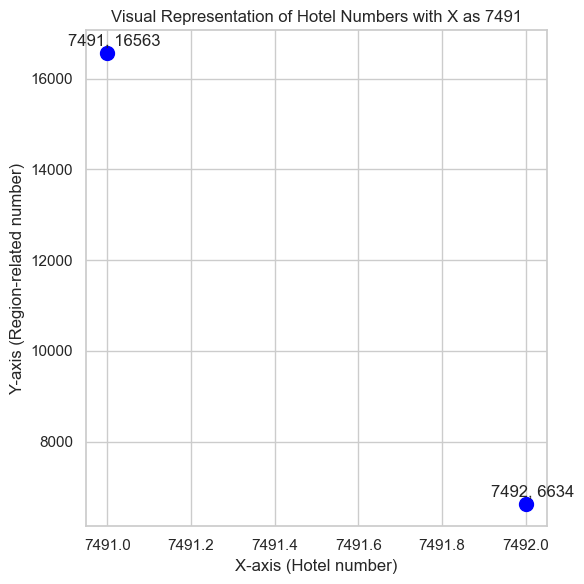

In [58]:
# Correcting the coordinates to place 7491 and 7492 on the X-axis for both points
x_coords = [7491, 7492]  # Both points on the same X-axis (7491)
y_coords = [16563, 6634]  # Different Y values based on the example

# Creating the scatter plot again with corrected coordinates
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, color='blue', s=100)

# Adding annotations for the points
for i, txt in enumerate(["7491, 16563", "7492, 6634"]):
    plt.annotate(txt, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(5,5), ha='center')

# Labeling the axes
plt.xlabel('X-axis (Hotel number)')
plt.ylabel('Y-axis (Region-related number)')

# Adding title and grid for better visualization
plt.title('Visual Representation of Hotel Numbers with X as 7491')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()